<a href="https://colab.research.google.com/github/IZProjects/AI-Notebooks/blob/main/WQ_Prediction_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install fastai

In [ ]:
from fastai.tabular.all import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
import numpy as np

In [ ]:
cont_names = ["ph", "Hardness", "Solids", "Chloramines", "Sulfate", "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"]
y_name = "Potability"

In [ ]:
CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/AI Stuff/Water Quality NN/data.csv'
df = pd.read_csv(CSV_PATH)

In [ ]:
df[cont_names] = df[cont_names].apply(lambda s: s.fillna(s.median()))

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [ ]:
to = TabularPandas(
    df,
    procs=[Normalize],
    cont_names=cont_names,
    y_names=y_name,
    y_block=CategoryBlock(),
    splits=splits
)

In [ ]:
dls = to.dataloaders(bs=256)

In [ ]:
dls.show_batch()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,3.722501,163.639740,37962.167969,6.684570,326.694031,467.562958,14.567269,50.577980,3.662838,0
1,5.964066,241.030899,22168.332031,6.208118,333.073547,486.516876,13.172989,64.719238,4.696721,0
2,14.000000,235.677460,24008.992188,5.635029,381.097717,460.745270,13.452538,72.859467,3.170994,0
3,5.335689,178.640121,37993.183594,9.772522,343.258362,465.072784,14.834257,65.326530,3.921976,1
4,6.070091,161.530273,26764.494141,6.241527,333.073547,485.866272,18.780519,81.946106,4.699458,0
5,10.337671,163.276230,21820.294922,7.899521,356.179626,561.206238,14.116323,56.193062,5.063109,0
6,8.205551,204.665833,17414.521484,6.839622,276.770111,346.540741,12.505602,83.916748,5.129528,1
7,7.022285,169.188736,18408.294922,5.131839,342.937683,350.894348,19.334232,86.677330,6.739000,0
8,6.028349,225.674866,12145.543945,6.126270,365.961700,503.112152,15.651889,73.400581,3.142084,1
9,6.103731,184.328690,17977.525391,7.275531,333.073547,334.949738,7.655381,59.000668,3.383049,1


In [ ]:
learn = tabular_learner(
    dls,
    metrics=[accuracy,RocAucBinary()]
)

SuggestedLRs(valley=0.0014454397605732083)

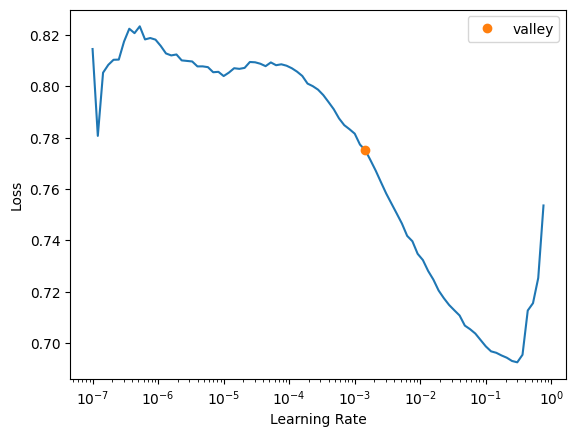

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.795612,0.704013,0.463740,0.479511,00:00
1,0.754650,0.712566,0.459924,0.507856,00:00
2,0.707767,0.684881,0.562977,0.603392,00:00
3,0.674191,0.656936,0.595420,0.635563,00:00
4,0.650288,0.655018,0.610687,0.645819,00:00
5,0.631162,0.644779,0.622137,0.673052,00:00
6,0.613338,0.643296,0.629771,0.669257,00:00
7,0.599851,0.641698,0.631679,0.673677,00:00
8,0.590565,0.642989,0.645038,0.673082,00:00
9,0.580037,0.643744,0.646947,0.672656,00:00


In [ ]:
learn.show_results()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,Potability_pred
0,-0.478067,0.983082,0.833999,-0.104676,-0.028398,-0.345388,0.376471,1.611695,-0.287390,0.0,0.0
1,-2.050912,0.441187,1.231135,-0.164387,-0.028398,-0.883375,0.056025,-0.481217,0.599996,0.0,0.0
2,-0.883353,-1.407880,0.752434,-1.292379,-0.028398,0.483232,-0.652641,-0.019128,0.142641,0.0,0.0
3,-0.058375,-0.244501,-0.979296,0.146709,-0.090851,-0.930555,0.737907,0.715731,0.281467,0.0,0.0
4,0.465027,1.057404,-0.029657,-0.139160,-0.028398,-0.383108,0.219023,1.654564,-0.191417,0.0,0.0
5,-0.204926,0.029451,0.174569,0.291836,-0.498822,0.908630,-0.818526,-2.151664,-0.597566,0.0,0.0
6,-0.378431,-0.464763,0.798621,0.107845,-0.210488,-0.634490,1.097063,0.607541,-1.627023,0.0,0.0
7,-0.447236,1.208962,-0.348545,0.726562,-0.028398,1.048129,0.573027,0.726242,-0.853462,0.0,1.0
8,-0.185689,-0.528494,-0.577148,-0.049249,0.961775,-1.560245,1.348803,-0.209150,-0.159537,1.0,0.0


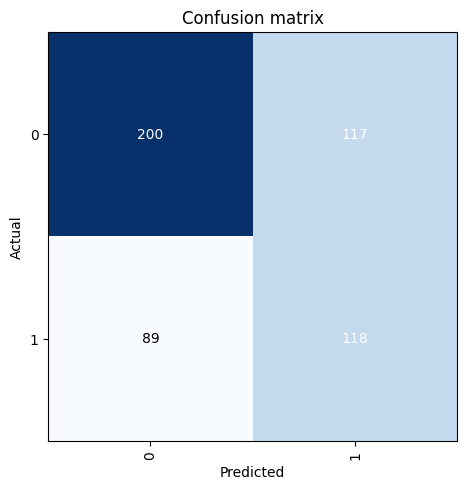

In [ ]:
# Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

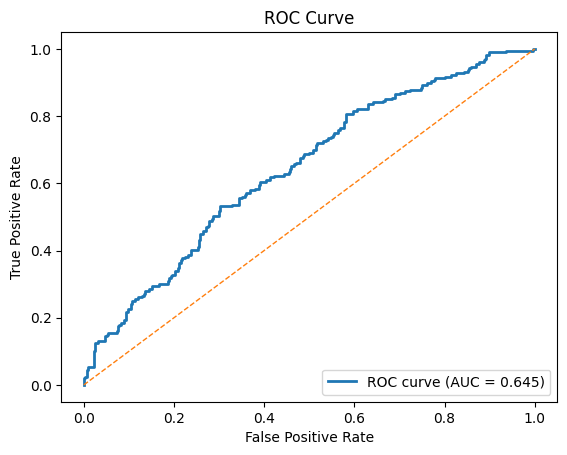

In [ ]:
# ROC curve
# fastai doesn't auto-plot ROC, but we can get preds and draw quickly:
import matplotlib.pyplot as plt
probs, targs = learn.get_preds()
# probs is Nx2 for CE loss; take positive class
pos_probs = probs[:,1].cpu().numpy()
targs_np = targs.cpu().numpy()

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(targs_np, pos_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()